analysis and plot output of filterTGapsMetric

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def to_array(x):
    '''converters to convert csv string to numpy array, used to load csv file'''
    arrstr = x.replace('[','').replace(']', '')
    arr = np.fromstring(arrstr, sep=' ')
    return arr


In [3]:
def cal_diffmat(df, night=[0, 400]):
    '''calculate time gaps matrix from visit timeCol of two filters, between night[0]~night[1]'''
    # # check start MJD is same as in the database
    startMJD = 59853.985644 + night[0]
    endMJD = 59853.985644 + night[1]
    t_f0 = df['t_f0'] [ (df['t_f0']>=startMJD) & (df['t_f0']<=endMJD) ]
    t_f1 = df['t_f1'] [ (df['t_f1']>=startMJD) & (df['t_f1']<=endMJD) ]
    
    t_f0 = t_f0.reshape((len(t_f0), 1))
    t_f1 = t_f1.reshape((len(t_f1), 1))
    
    diffmat = np.abs( np.subtract(t_f0, t_f1.T) )
    
    return diffmat


In [4]:
def cal_dT(df):
    '''collect all time gaps'''
    
    if df.f0==df.f1:
        # get only triangle part
        dt_tri = np.tril(df['diffmat'], -1)
        dT = dt_tri[dt_tri!=0]    # flatten lower triangle 

    else:
        dT = df['diffmat'].flatten()
    
    return dT


In [5]:
def KL_div(px, qx):
    '''calculate KL divergences D(P||Q)'''
    kl = np.sum( px * np.log(px / qx) )
    return kl


In [58]:
np.NaN

nan

In [86]:
arr = np.array([0,0,0,0])
arr.any()

False

In [88]:
def get_Dkl(values):
    '''kl divergence for histogram'''
    if values.any():
        values = values + 0.00001  # make each element non-zero
        prob = (values) / values.sum()  
    
        prob_uni = np.ones( len(prob) ) / len(prob)
        return KL_div(prob_uni, prob) 
    
    else:
        return np.NaN
        

In [132]:
def get_hist_dict(dbfile='', path='', night=[0,400], 
                  tmin=[0, 0], tmax=[1.5, 1.5], 
                  histbins=[20, 20] ):
    """
    get histogram values for each filter pair, return dict, 
    tmin, tmax, histbins[0] for same filter, 
    tmin, tmax, histbins[1] for different filter
    """
    
    filename = path + dbfile
    df_all = pd.read_csv(filename, 
                 converters={'t_f0':to_array, 't_f1':to_array})
    
    print('loaded ', filename)

    # calculate dT
    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    
    flt = ['u', 'g', 'r', 'i', 'z', 'y']

    filter_dict = {} 
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            # filename = 'data/tFilter_{}{}_{}.pkl'.format(f0, f1, dbname)
            #df = pd.read_pickle(filename)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()
            
            f0f1 = '{}{}'.format(f0,f1)
            filter_dict[ f0f1 ] = {}
            #axs[fdict[f0], fdict[f1]].hist(dT[dT<1/24],bins=100); 
            if f0==f1:
                # concatenate dT
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24
                
                dT_tlim = dT[(dT>tmin[0])&(dT<tmax[0])] 
                Ntotal = len(dT_tlim)

                values, bins_ = np.histogram(dT_tlim, bins=histbins[0]);
                                
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['Nv'] = len(dT_tlim)
                filter_dict[ f0f1 ]['Dkl'] = get_Dkl( values )
                filter_dict[ f0f1 ]['eDkl'] = np.exp(- get_Dkl( values ) )
                
            else:
      
                #df['diffmat'] = df.apply(cal_diffmat, axis=1)
                #df['dT'] = df.apply(cal_dT, axis=1)
                
                dT = np.concatenate(df['dT'].values) * 24   # convert to hour
                
                dT_tlim = dT[(dT>tmin[1])&(dT<tmax[1])]

    
                Ntotal = len(dT_tlim)
        
                values, bins_ = np.histogram(dT_tlim, bins=histbins[1] );

                # save to dict 
                filter_dict[ f0f1 ]['dT'] = dT_tlim
                filter_dict[ f0f1 ]['values'] = values
                filter_dict[ f0f1 ]['bins'] = bins_
                filter_dict[ f0f1 ]['Nv'] = len(dT_tlim)
                filter_dict[ f0f1 ]['Dkl'] = get_Dkl( values )
                filter_dict[ f0f1 ]['eDkl'] = np.exp(- get_Dkl( values ) )
    
    return filter_dict


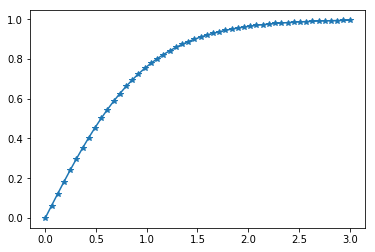

In [34]:
x = np.linspace(0, 3)
y = np.tanh(x)
plt.plot(x, y, '*-')

In [ ]:
np.diff()

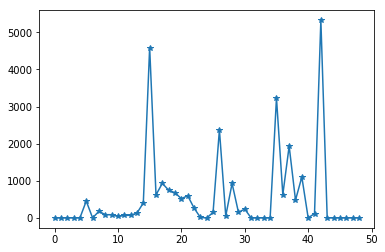

In [133]:
plt.plot(df['uu']['values'], '*-')


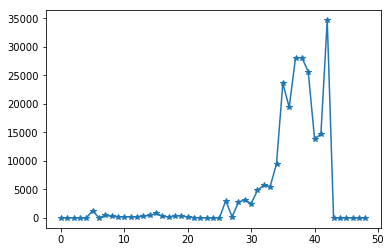

In [126]:
plt.plot(values, '*-')

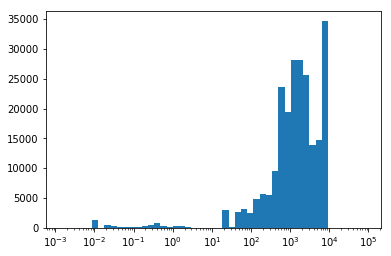

In [124]:
values, bins, _ = plt.hist( df['rr']['dT'], bins=bins_log);
plt.xscale('log')

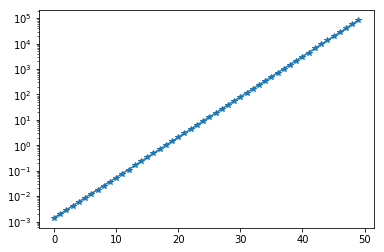

In [108]:
plt.plot(bins_log, '-*')
plt.yscale('log')

(array([81542., 46448., 35049., 14033.,  6543.,  4852., 10376., 14537.,
        12060.,  5835.]),
 array([9.16655984e-03, 9.40089534e+02, 1.88016990e+03, 2.82025027e+03,
        3.76033064e+03, 4.70041100e+03, 5.64049137e+03, 6.58057174e+03,
        7.52065210e+03, 8.46073247e+03, 9.40081284e+03]),
 <a list of 10 Patch objects>)

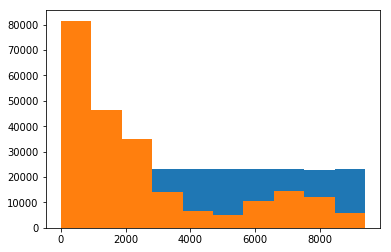

In [146]:
data = df['rr']['dT']

uni = np.random.uniform(low=data.min(), high=data.max(), size=len(data) )

plt.hist(uni,)
plt.hist(data,)

In [191]:
%%time
# 5 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(5/60/60), np.log10(3e8/60./60.), 50)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
filter_dict = get_hist_dict(dbfile=dbfile, path=path , night=[0, 4000], 
                  tmin=[30/60/60, 5/60/60], tmax=[4000*24, 1.5], histbins=[bins_log, 50])  


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
CPU times: user 1min 48s, sys: 15.5 s, total: 2min 4s
Wall time: 2min 4s


In [193]:
df = pd.DataFrame(filter_dict)
df

,uu,ug,ur,ui,uz,uy,gg,gr,gi,gz,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
Dkl,6.30097,1.22573,0.712665,0.12185,NaN,7.60095,5.49098,1.72248,0.740531,0.449147,...,5.81071,1.20863,0.582093,0.136786,5.89269,1.48963,0.404672,5.75953,1.02821,5.97522
Nv,2350946,20446,8260,1631,0,10,4319998,141713,22586,2766,...,25073142,156999,24350,2288,25454405,186503,24135,20729265,126901,22471448
bins,"[0.0013888888888888887, 0.0020017290144679627,...","[0.04194431996438652, 0.07110450716572814, 0.1...","[0.04194431996438652, 0.0711041663645301, 0.10...","[0.04194431996438652, 0.07110245276475326, 0.1...","[0.0, 0.02, 0.04, 0.06, 0.08, 0.1, 0.12, 0.14,...","[0.13240152003709227, 0.1597165680374019, 0.18...","[0.0013888888888888887, 0.0020017290144679627,...","[0.04194431996438652, 0.07110358556499705, 0.1...","[0.04194431996438652, 0.07110221276641823, 0.1...","[0.04194431996438652, 0.07107991196564399, 0.1...",...,"[0.0013888888888888887, 0.0020017290144679627,...","[0.04194431996438652, 0.07109581436379812, 0.1...","[0.04194431996438652, 0.07110505916294642, 0.1...","[0.041944320139009506, 0.07110045613604597, 0....","[0.0013888888888888887, 0.0020017290144679627,...","[0.04194431996438652, 0.07110207356396131, 0.1...","[0.04194431996438652, 0.07110540476627648, 0.1...","[0.0013888888888888887, 0.0020017290144679627,...","[0.04194431996438652, 0.0711052511644084, 0.10...","[0.0013888888888888887, 0.0020017290144679627,..."
dT,"[0.3508279199595563, 0.6838425599271432, 0.333...","[0.38441424001939595, 0.385350719850976, 0.411...","[0.4058025599224493, 1.3237291200784966, 0.426...","[1.1443113600835204, 1.1344336799229495, 0.091...",[],"[0.5154012000421062, 0.13240152003709227, 0.88...","[0.4007704799878411, 1.625632559938822, 1.2248...","[1.108951440139208, 1.0997848801198415, 1.0906...","[1.1655369600048289, 1.4970551999285817, 0.783...","[0.041944320139009506, 0.34952039999188855, 0....",...,"[0.009166560019366443, 0.01833335997071117, 0....","[0.3908800801145844, 0.3860736001515761, 0.771...","[1.1531527200713754, 1.3545081600314006, 0.803...","[1.1529935999424197, 1.2131704801577143, 0.400...","[8065.021345680056, 8922.809958720056, 857.788...","[0.3880219199345447, 0.7670791199197993, 0.968...","[1.350935039925389, 0.9652010399149731, 1.0425...","[8946.345240480092, 16034.143698240048, 7087.7...","[0.5838559200055897, 0.3825004800455645, 0.388...","[0.3839193598832935, 6723.117611040012, 6722.7..."
eDkl,0.00183453,0.293543,0.490336,0.885282,NaN,0.000499976,0.00412379,0.178622,0.476861,0.638172,...,0.00299529,0.298605,0.558728,0.872157,0.00275954,0.225456,0.667195,0.0031526,0.357646,0.00254093
values,"[0, 0, 0, 0, 0, 3361, 21, 1170, 593, 543, 327,...","[22, 10, 7, 6, 13, 6, 11, 15, 24, 38, 213, 430...","[14, 4, 8, 4, 5, 10, 13, 8, 18, 32, 111, 1100,...","[11, 7, 12, 7, 12, 5, 27, 17, 29, 25, 24, 30, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, ...","[0, 0, 0, 0, 0, 4674, 30, 1575, 793, 723, 417,...","[227, 115, 76, 64, 55, 66, 72, 74, 166, 506, 1...","[28, 8, 17, 12, 15, 26, 36, 47, 54, 64, 46, 80...","[47, 47, 52, 80, 81, 84, 107, 130, 123, 145, 1...",...,"[0, 0, 0, 0, 0, 12296, 246, 4255, 2356, 2391, ...","[292, 183, 156, 165, 194, 228, 248, 272, 358, ...","[11, 15, 23, 48, 49, 51, 64, 65, 85, 104, 81, ...","[5, 5, 5, 17, 17, 24, 24, 26, 27, 34, 29, 61, ...","[0, 0, 0, 0, 0, 12206, 146, 4247, 2464, 2399, ...","[301, 163, 139, 127, 137, 165, 180, 246, 274, ...","[30, 45, 66, 58, 73, 116, 121, 175, 177, 181, ...","[0, 0, 0, 0, 0, 11238, 215, 3808, 2276, 2222, ...","[189, 110, 88, 92, 108, 112, 125, 159, 196, 75...","[0, 0, 0, 0, 0, 11021, 72, 3730, 2088, 1980, 1..."


In [194]:
def plot_hist(filter_dict, histbins=[50, 50], **kwargs):
    """plot histogram"""
    fig, axs = plt.subplots(6, 6, figsize=(20, 20), constrained_layout=True); # 6 axes on a 2x3 grid
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    fdict = {'u':0, 'g':1, 'r':2, 'i':3, 'z':4, 'y':5}
    
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            dT = filter_dict[key] ['dT']
            eDkl = filter_dict[key] ['eDkl']
                        
            if f0==f1:
                ax = axs[fdict[f0], fdict[f1]]
                # plot a uniform distribution
                if len(dT)!=0:
                    values, bins, _ = ax.hist(dT, bins=histbins[0], **kwargs );
                    
                    
                    low = np.log(dT.min())
                    high = np.log(dT.max())
                    uni = np.power(10, np.random.uniform(low=low, high=high, size=len(dT) ) )
                    _ = ax.hist(uni, bins=histbins[0], **kwargs );
                
                ax.set_xscale("log")
    
            else:
            
                axs[fdict[f0], fdict[f1]].axis('off')
                ax = axs[fdict[f1], fdict[f0]]
                
                # plot a uniform distribution
                if len(dT)!=0:
                    values, bins, _ = ax.hist(dT, bins=histbins[1], **kwargs );

                    uni = np.random.uniform(low=dT.min(), high=dT.max(), size=len(dT) )

                    _ = ax.hist(uni, bins=histbins[1], **kwargs );
                
            #values, bins, _ = ax.hist(dT, **kwargs );
            
            title = '{}{} Nv={} $D_k$={:.2f}'.format(f0, f1, len(dT), filter_dict[key] ['Dkl'])
            ax.set_title(title)
    
            #ax.set_xlabel('Nvisits')
            #ax.set_ylabel('N fields')


In [101]:
filter_dict.keys()

dict_keys(['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy'])

In [166]:
len(df['rr']['dT'])

231275

In [174]:
np.exp( np.min(bins_log) )

1.0013898538417474

In [172]:
5/60/60

0.0013888888888888887

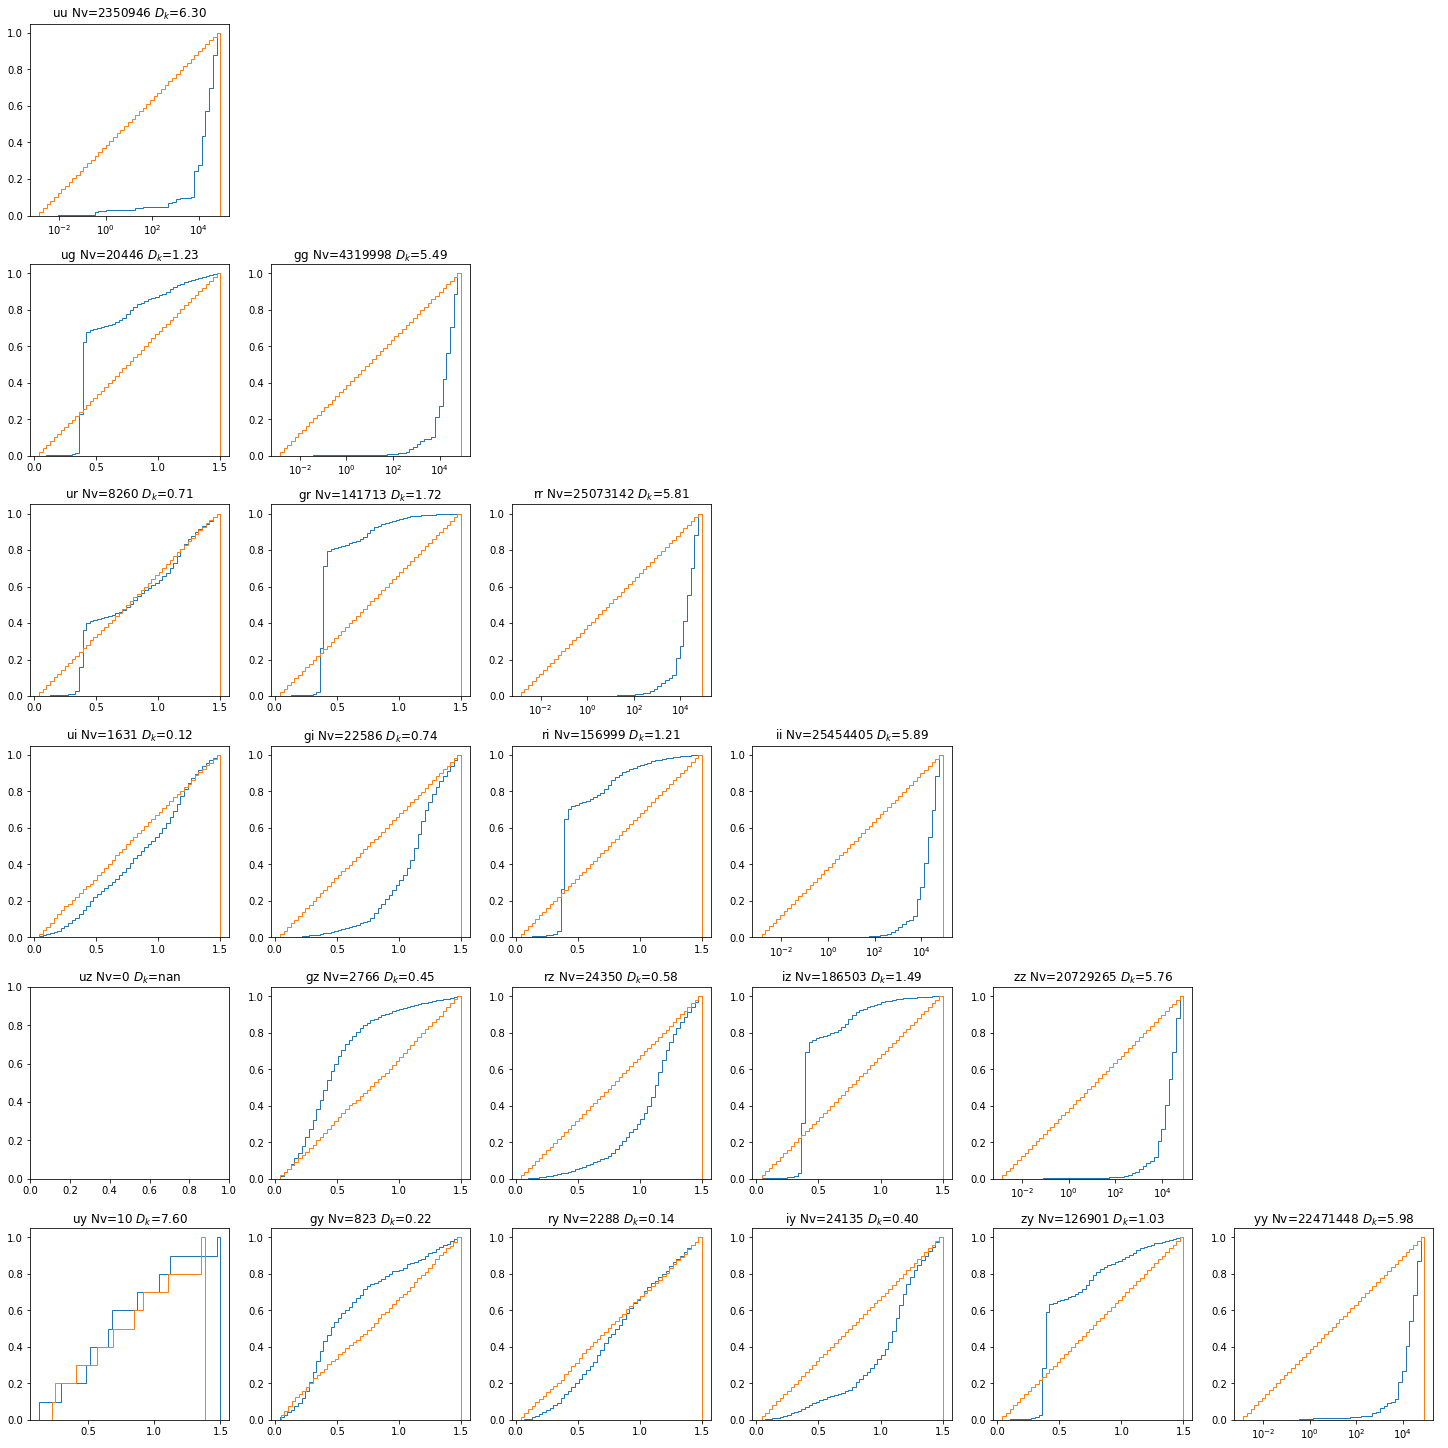

In [195]:
plot_hist(filter_dict, histbins=[bins_log, 50], cumulative=True, density=True, histtype='step')


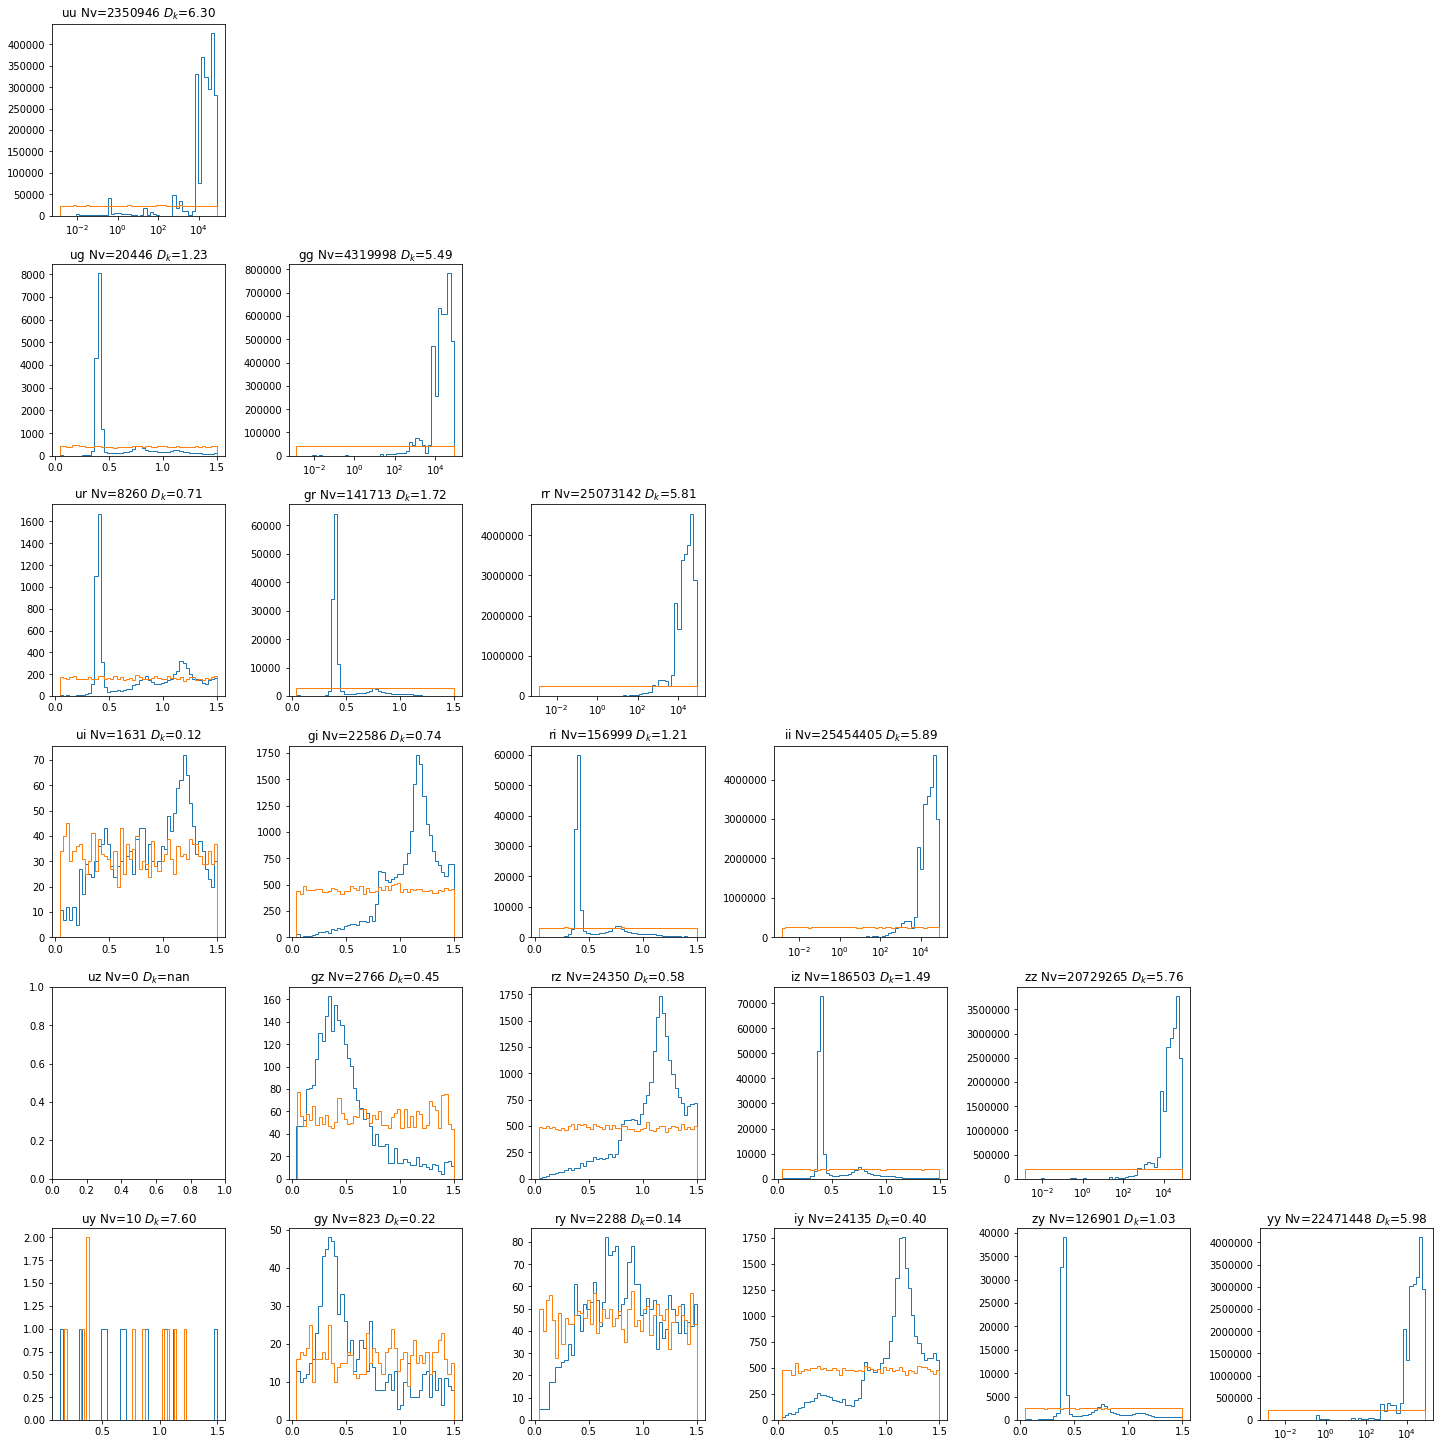

In [196]:
plot_hist(filter_dict, histbins=[bins_log, 50], cumulative=False, density=False, histtype='step')


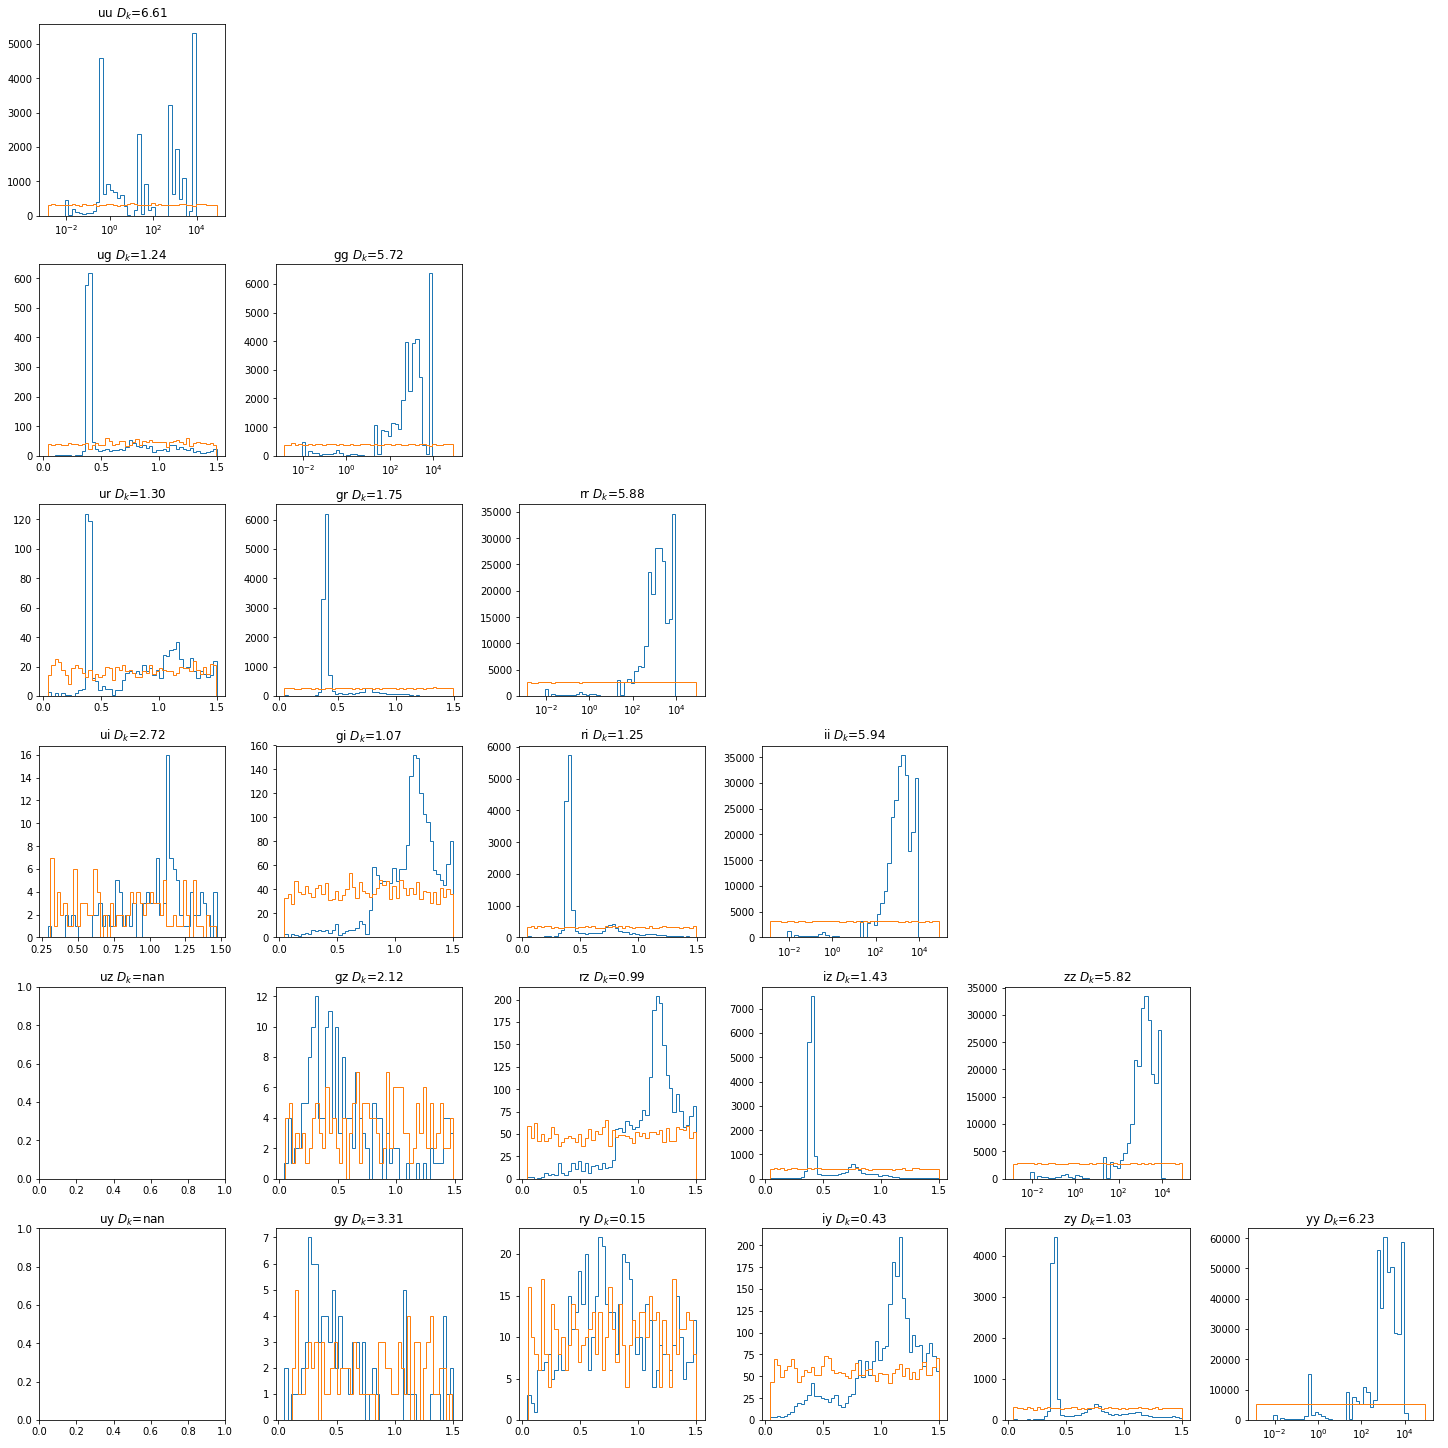

In [190]:
plot_hist(filter_dict, histbins=[bins_log, 50], cumulative=False, density=False, histtype='step')
# one year 

/home/idies/lsst/python/miniconda3-4.7.10/envs/lsst-scipipe-4d7b902/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


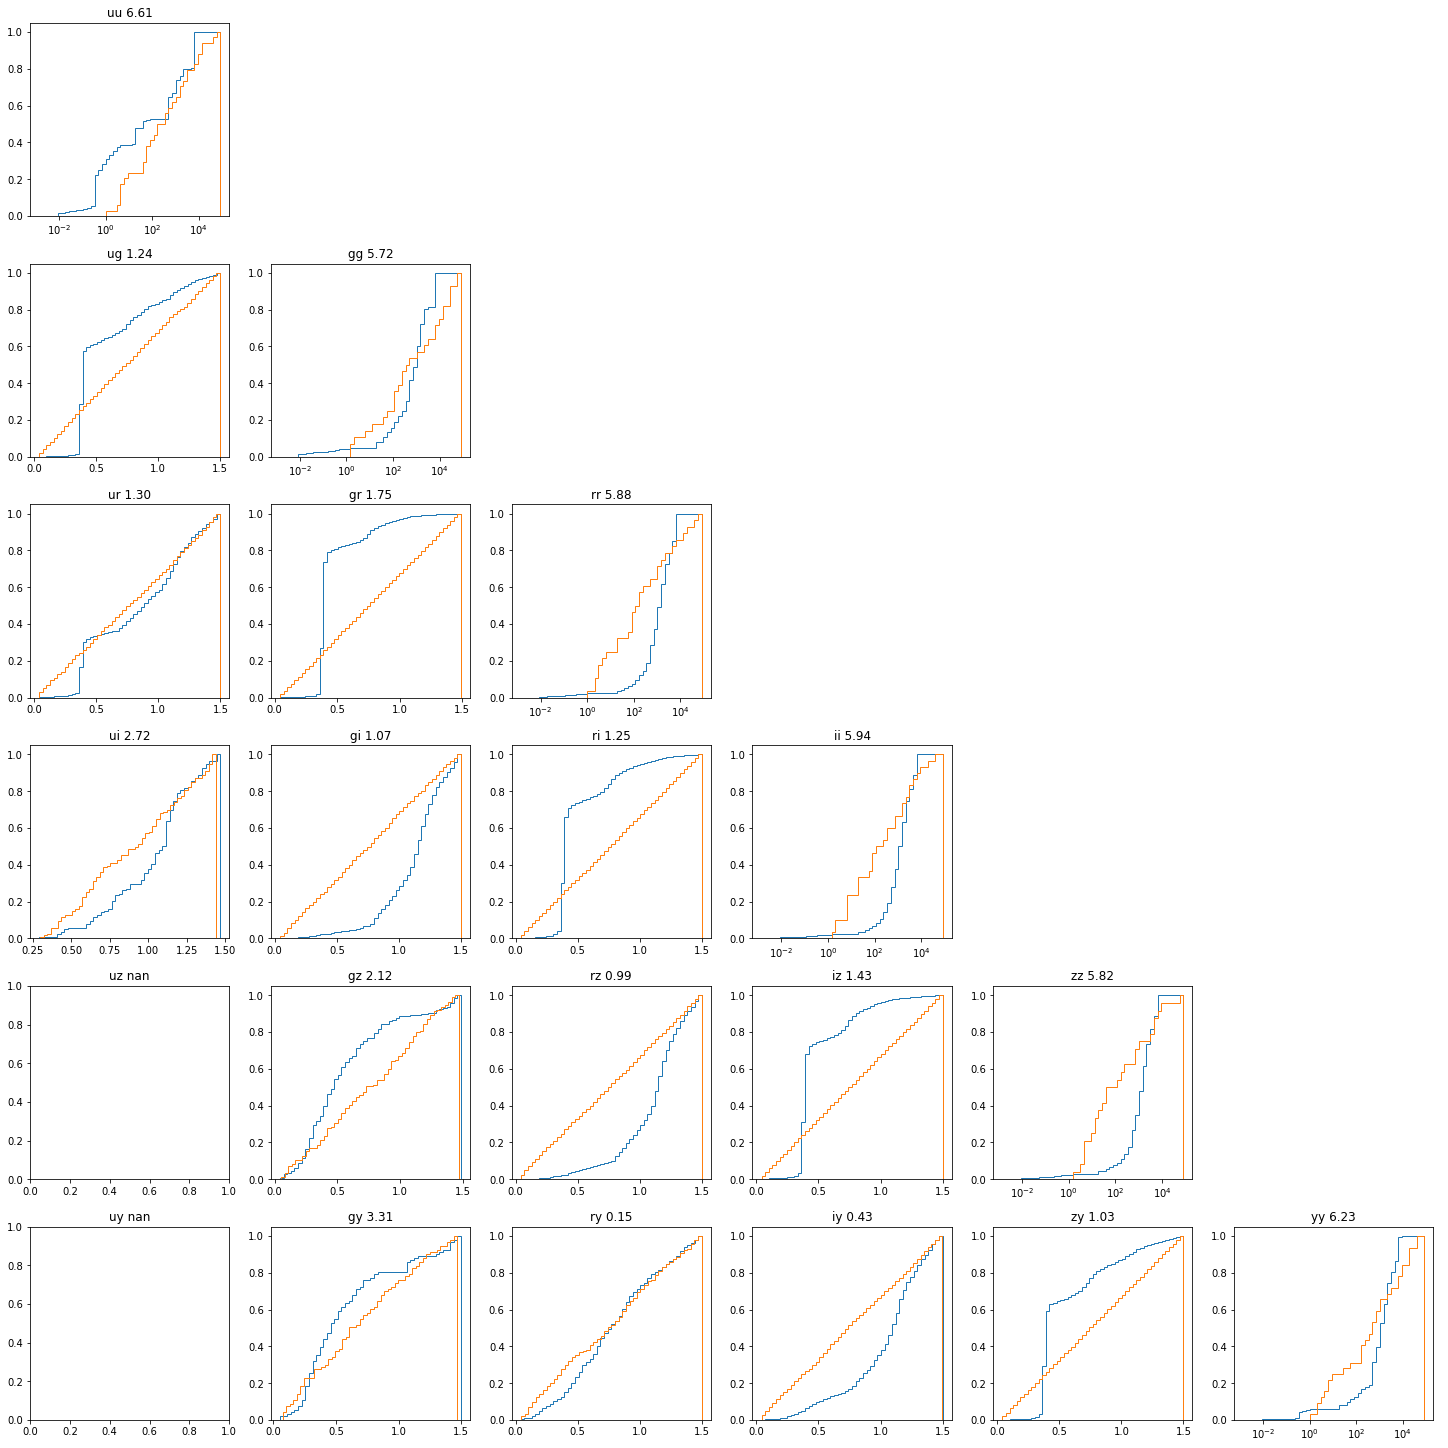

In [168]:
plot_hist(filter_dict, histbins=[bins_log, 50], cumulative=True, density=True, histtype='step')



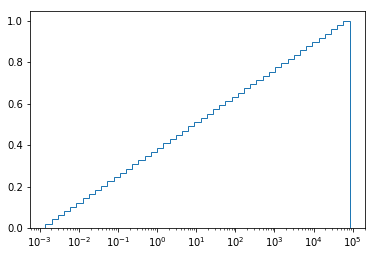

In [181]:
low = np.log(bins_log.min())
high = np.log(bins_log.max())
uni = np.power(10, np.random.uniform(low=low, high=high, size=2000000 ) )
plt.hist(uni, bins=bins_log, density=True, cumulative=True, histtype='step'); 
plt.xscale('log')

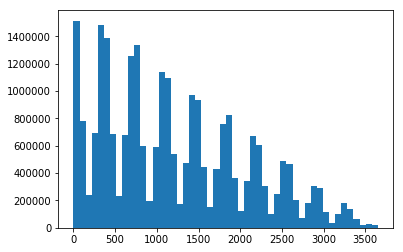

In [41]:
plt.hist(df['rr']['dT'] / 24, bins=50);

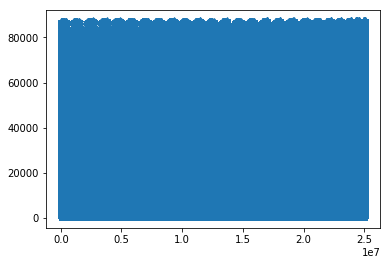

In [52]:
plt.plot(df['rr']['dT'], '*') 

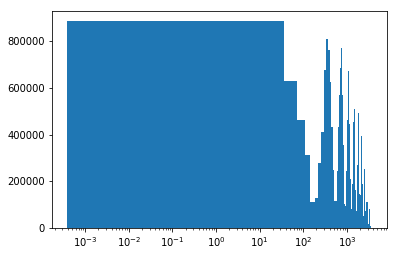

In [51]:
_ =plt.hist( df['rr']['dT']/24, bins=100, cumulative=False, density=False);
plt.xscale('log')

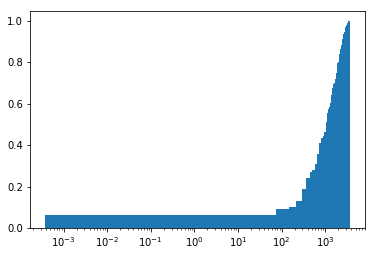

In [42]:
plt.hist( df['rr']['dT']/24, bins=50, cumulative=True, density=True);
plt.xscale('log')

In [53]:
def get_fom_Nv(dbfile='', path='' , night=[0,400], 
                  tmin=[5/60/60, 5/60/60], tmax=[400*24, 1.5], bins=[50, 50]):
    '''get fom for each filter pair'''

    filter_dict = get_hist_dict(dbfile=dbfile, path=path , night=night, 
                  tmin=tmin, tmax=tmax, bins=bins)
    
    print('calculating FOM of {}...'.format( dbfile ) )

    flt = ['u', 'g', 'r', 'i', 'z', 'y']


    '''
    # get total Nvisits for normalization  
    N_total_same = 0
    N_total_diff = 0
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            key = '{}{}'.format(f0, f1)
            if f0==f1:
                
                N_total_same += len( filter_dict[key]['dT'] )
                
            else:
                
                N_total_diff += len( filter_dict[key]['dT'] )
                
    '''
    
    # calcuate figure of merit for each filter pair
    fom_dict = {}
    Nv_dict = {}
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:  
        
            key = '{}{}'.format(f0, f1)
            
            fom_dict[key] = filter_dict[key]['Nv'] * filter_dict[key]['eDkl']
            Nv_dict[key] = filter_dict[key]['Nv']
            # print(key, fom)

    return fom_dict, Nv_dict


In [54]:
%%time
# 5 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(5/60/60), np.log10(3e8/60./60.), 50)

dbfile = 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv'
path = '/home/idies/workspace/Temporary/lixl/scratch/'
fom_dict, Nv_dict = get_fom_Nv(dbfile=dbfile, path=path , night=[0, 4000], 
                  tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], bins=[bins_log, 50])  


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv...
CPU times: user 1min 27s, sys: 0 ns, total: 1min 27s
Wall time: 1min 27s


In [55]:
fom_dict, Nv_dict

({'uu': 4312.875388898785,
  'ug': 6001.789076579262,
  'ur': 4050.1740286474974,
  'ui': 1443.8941409759657,
  'uz': 0.0,
  'uy': 0.004999760011959396,
  'gg': 17814.744009200822,
  'gr': 25313.108937531262,
  'gi': 10770.372747546402,
  'gz': 1765.1838614550463,
  'gy': 661.6603537189519,
  'rr': 75101.32763713154,
  'ri': 46880.69451300871,
  'rz': 13605.014833429954,
  'ry': 1995.4945604676254,
  'ii': 70242.35938988911,
  'iz': 42048.133445719825,
  'iy': 16102.761226164414,
  'zz': 65351.053584420704,
  'zy': 45385.685315314244,
  'yy': 57098.45801502137},
 {'uu': 2350946,
  'ug': 20446,
  'ur': 8260,
  'ui': 1631,
  'uz': 0,
  'uy': 10,
  'gg': 4319998,
  'gr': 141713,
  'gi': 22586,
  'gz': 2766,
  'gy': 823,
  'rr': 25073142,
  'ri': 156999,
  'rz': 24350,
  'ry': 2288,
  'ii': 25454405,
  'iz': 186503,
  'iy': 24135,
  'zz': 20729265,
  'zy': 126901,
  'yy': 22471448})

In [50]:
list( fom_dict.values() )

[4312.875388898785,
 6001.789076579262,
 4050.1740286474974,
 1443.8941409759657,
 0.0,
 0.004999760011959396,
 17814.744009200822,
 25313.108937531262,
 10770.372747546402,
 1765.1838614550463,
 661.6603537189519,
 75101.32763713154,
 46880.69451300871,
 13605.014833429954,
 1995.4945604676254,
 70242.35938988911,
 42048.133445719825,
 16102.761226164414,
 65351.053584420704,
 45385.685315314244,
 57098.45801502137]

In [56]:
# run for all opsim dbs 
import glob
dbpath = '/home/idies/workspace/lsst_cadence/FBS_1.4/'
os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
dblist_all.sort()
workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'
os.chdir(workpath) # change back to work directory

In [57]:
dblist_all

['agnddf_v1.4_10yrs.db',
 'alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db',
 'baseline_2snapsv1.4_10yrs.db',
 'baseline_v1.4_10yrs.db',
 'bulges_bs_v1.4_10yrs.db',
 'bulges_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_bs_v1.4_10yrs.db',
 'bulges_cadence_bulge_wfd_v1.4_10yrs.db',
 'bulges_cadence_i_heavy_v1.4_10yrs.db',
 'bulges_i_heavy_v1.4_10yrs.db',
 'dcr_nham1_v1.4_10yrs.db',
 'dcr_nham2_v1.4_10yrs.db',
 'dcr_nham3_v1.4_10yrs.db',
 'dcr_nham4_v1.4_10yrs.db',
 'dcr_nham5_v1.4_10yrs.db',
 'descddf_v1.4_10yrs.db',
 'euclidddf_v1.4_10yrs.db',
 'footprint_add_mag_cloudsv1.4_10yrs.db',
 'footprint_big_sky_dustv1.4_10yrs.db',
 'footprint_big_sky_nouiyv1.4_10yrs.db',
 'footprint_big_skyv1.4_10yrs.db',
 'footprint_bluer_footprintv1.4_10yrs.db',
 'footprint_gp_smoothv1.4_10yrs.db',
 'footprint_newAv1.4_10yrs.db',
 'footprint_newBv1.4_10yrs.db',
 'footprint_no_gp_northv1.4_10yrs.db',
 'footprint_standard_goalsv1.4_10yrs.db',
 'footprint_stuck_rollingv1.4_10yrs.db',
 'pair_strategy_0_v1.4_10yrs.db',
 

In [58]:
%%time
# path to output of metric for all opsims
path = '/home/idies/workspace/Temporary/lixl/scratch/'

# 5 sec to 10yrs(~3e8)
bins_log=np.logspace(np.log10(5/60/60), np.log10(3e8/60./60.), 50)

#cols = ['db', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

for dbname in dblist_all:
    dbfile = 'tGaps_{}_nside16_proposalId=1.csv'.format(dbname)
    fom_dict, Nv_dict = get_fom_Nv(dbfile=dbfile, path=path , night=[0, 4000], 
                  tmin=[5/60/60, 5/60/60], tmax=[4000*24, 1.5], bins=[bins_log, 50])  
    
    print('saving FOM and Nv of {}'.format(dbname) )
    
    with open('tgaps_fom.csv', 'a') as f:
        lsr = "{}, {}".format(dbname, list( fom_dict.values() ) ).replace('[','').replace(']', '') 
        f.write("{}\n".format(lsr) )
    
    with open('tgaps_Nv.csv', 'a') as f:
        lsr = "{}, {}".format(dbname, list( Nv_dict.values() ) ).replace('[','').replace(']', '') 
        f.write("{}\n".format(lsr) )
    

loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_agnddf_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_agnddf_v1.4_10yrs.db_nside16_proposalId=1.csv...
saving FOM and Nv of agnddf_v1.4_10yrs.db
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db_nside16_proposalId=1.csv...
saving FOM and Nv of alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_2snapsv1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_2snapsv1.4_10yrs.db_nside16_proposalId=1.csv...
saving FOM and Nv of baseline_2snapsv1.4_10yrs.db
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating FOM of tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1.csv...
saving FOM and Nv of baseline_v1.4_10yrs.db
loaded  /home/idies/wor

In [8]:
cols = ['db', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

df_fom = pd.read_csv('tgaps_fom.csv', names=cols)

In [9]:
df_fom.head()    # the DL divergence * number of visits as the final fom

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,agnddf_v1.4_10yrs.db,4544.843229,6264.486283,4155.813353,1367.352154,0.0,0.000000,14045.173837,26285.676793,10515.798583,...,77402.476733,49443.326724,14148.400703,2326.362408,69841.104994,43766.522831,17372.789561,63829.872611,49592.695892,83426.662137
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,2737.272201,5374.748149,3416.523632,1426.312658,0.0,0.002018,16142.370268,32398.194693,17898.546567,...,75313.427178,69883.468740,29251.681895,6218.358939,70713.736772,59440.742516,25220.509101,64199.658045,60872.418449,74414.667779
2,baseline_2snapsv1.4_10yrs.db,3931.133916,5292.750202,3001.678609,950.764424,0.0,0.000000,12782.268678,22679.251787,8829.890958,...,64856.547850,41622.790958,11296.014203,1733.947843,62503.613515,37782.372973,12866.809660,42679.015605,38358.327048,50458.505873
3,baseline_v1.4_10yrs.db,4312.875389,6001.789077,4050.174029,1443.894141,0.0,0.005000,17814.744009,25313.108938,10770.372748,...,75101.327637,46880.694513,13605.014833,1995.494560,70242.359390,42048.133446,16102.761226,65351.053584,45385.685315,57098.458015
4,bulges_bs_v1.4_10yrs.db,3552.670800,5747.936919,2730.096158,814.105245,0.0,0.012734,15206.590333,20153.331691,7784.499969,...,59349.872674,37032.971235,10799.755151,1691.863143,55743.998552,32862.760517,11271.111707,51993.997130,33509.317132,62253.204033


In [16]:
cols_all = ['uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

cols_same = [ 'uu',  'gg',  'rr',  'ii',  'zz',  'yy']

cols_diff = ['ug', 'ur', 'ui', 'uz', 'uy', 'gr', 'gi', 'gz', 'gy', 'ri', 'rz', 'ry', 'iz', 'iy', 'zy']


In [12]:
def scale(arr):
    '''scale to 0-1'''
    newarr = ( arr - arr.min() ) / (arr.max() - arr.min() )
    return newarr


In [18]:
df_fom[ ['db'] ]

,db
0,agnddf_v1.4_10yrs.db
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db
2,baseline_2snapsv1.4_10yrs.db
3,baseline_v1.4_10yrs.db
4,bulges_bs_v1.4_10yrs.db
5,bulges_bulge_wfd_v1.4_10yrs.db
6,bulges_cadence_bs_v1.4_10yrs.db
7,bulges_cadence_bulge_wfd_v1.4_10yrs.db
8,bulges_cadence_i_heavy_v1.4_10yrs.db
9,bulges_i_heavy_v1.4_10yrs.db


In [20]:
# scale to 0 and 1
df_new = df_fom[ ['db'] ].copy()
for col in cols_all:
    df_new[ col ] = np.tanh ( scale ( df_fom[col] ) * 3 )


In [24]:
np.unique( df_fom['uz'] )

array([0.])

In [31]:
df_new.fillna(0).to_csv('tgapsFOM.csv')

In [21]:
df_new.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,agnddf_v1.4_10yrs.db,0.433057,0.945630,0.838716,0.817376,NaN,0.000000,0.273876,0.945850,0.942789,...,0.148069,0.950079,0.855792,0.587165,0.137011,0.952279,0.929192,0.129106,0.970841,0.514567
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,0.272175,0.911227,0.761746,0.833165,NaN,0.000005,0.312233,0.976092,0.995055,...,0.144129,0.988811,0.989887,0.946786,0.138701,0.987143,0.983639,0.129846,0.988715,0.467942
2,baseline_2snapsv1.4_10yrs.db,0.380831,0.907169,0.705865,0.663387,NaN,0.000000,0.250342,0.912976,0.901466,...,0.124341,0.912578,0.769815,0.463581,0.122770,0.921964,0.840785,0.086581,0.925989,0.331023
3,baseline_v1.4_10yrs.db,0.413630,0.937107,0.829302,0.837628,NaN,0.000012,0.342113,0.938412,0.947346,...,0.143729,0.939949,0.842098,0.520893,0.137788,0.944999,0.910705,0.132148,0.958573,0.370741
4,bulges_bs_v1.4_10yrs.db,0.347338,0.927650,0.663687,0.594124,NaN,0.000031,0.295235,0.879375,0.862946,...,0.113879,0.879285,0.750923,0.453964,0.109606,0.883911,0.790240,0.105358,0.890326,0.400675


In [26]:
plt.style.use('seaborn')

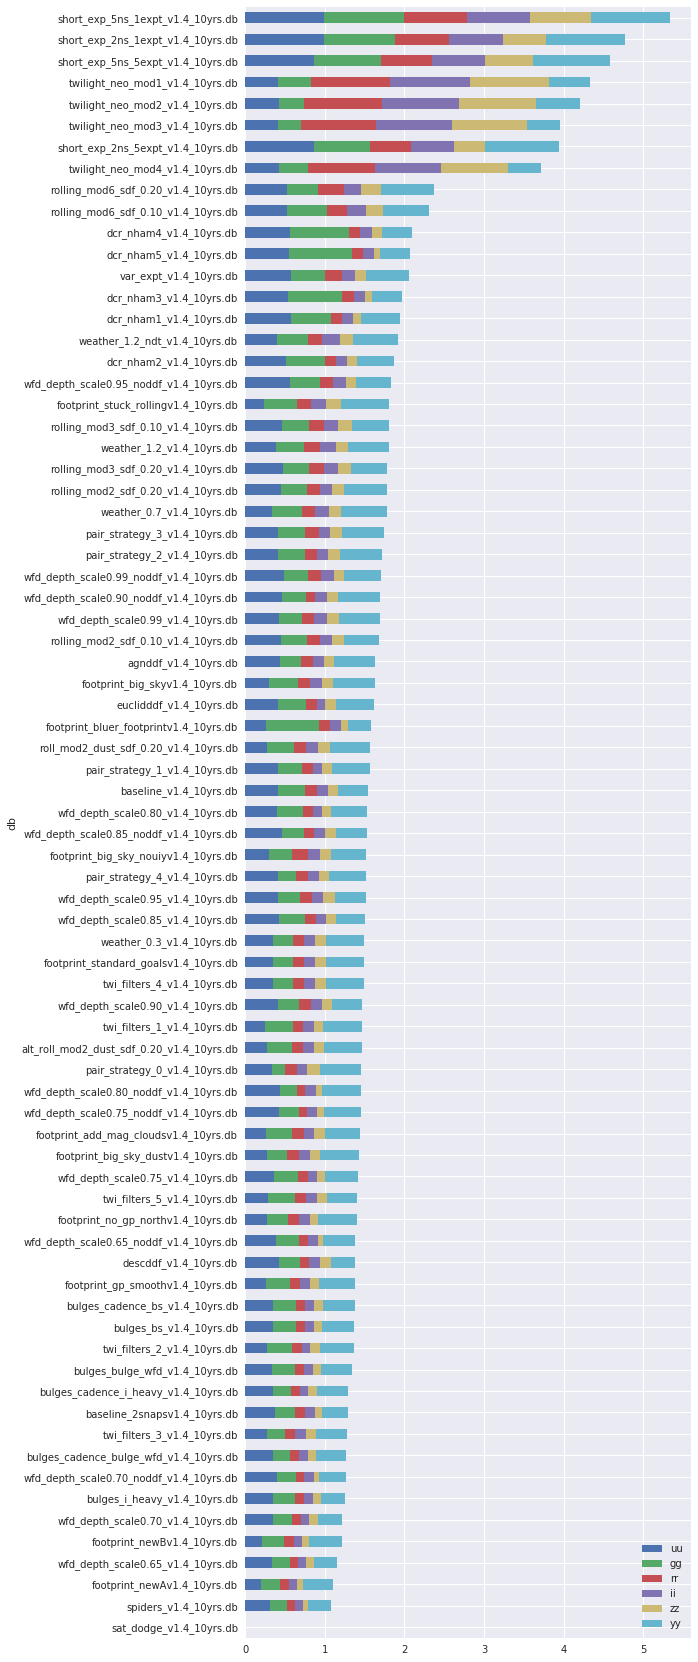

In [27]:
df_ = df_new.set_index('db')

colon = cols_same
df_['total'] = np.sum(df_[ colon ], axis=1)

df_ = df_.sort_values(by='total', ascending=True)
df_[ colon ].plot.barh(stacked=True, figsize=(8, 30))


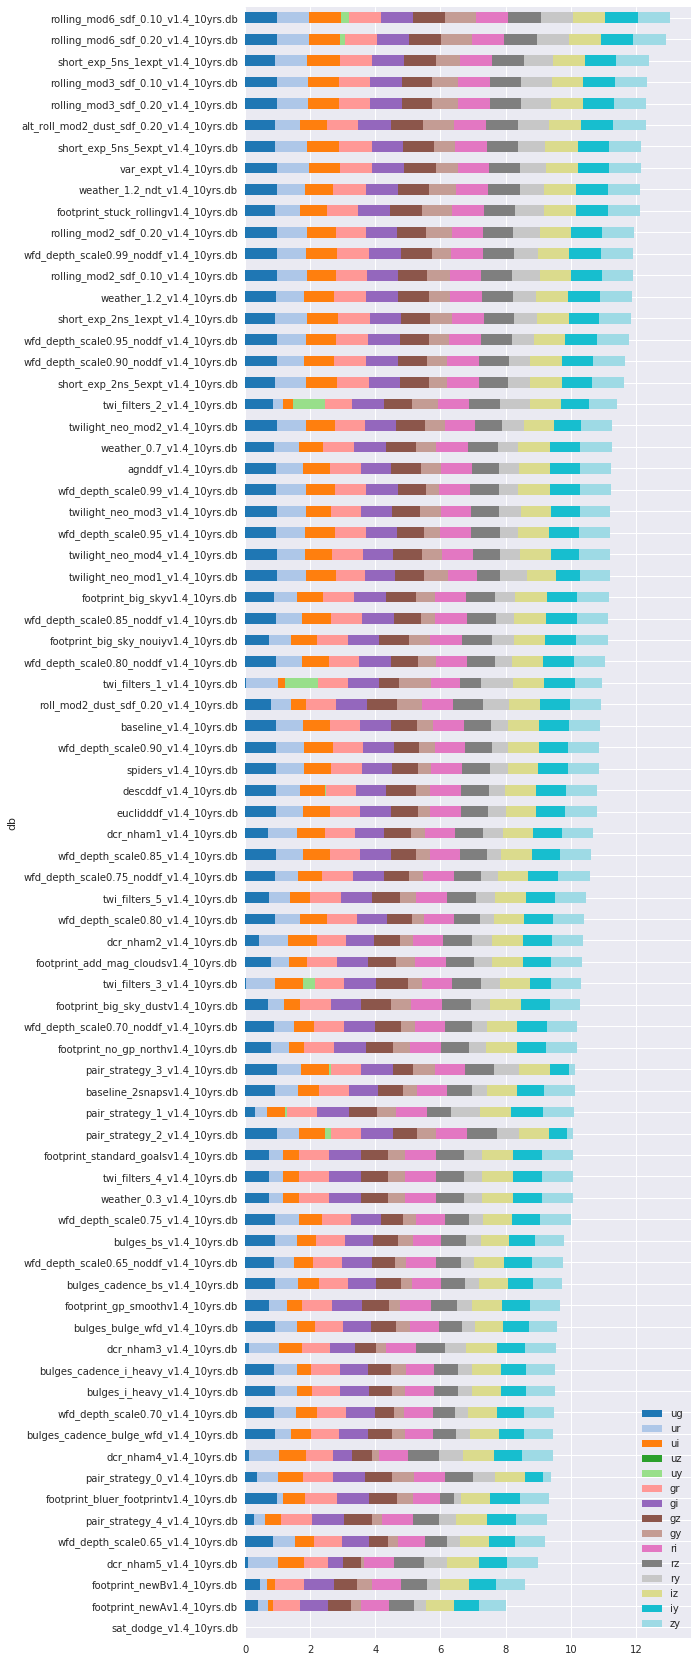

In [29]:
df_ = df_new.set_index('db')

colon = cols_diff
df_['total'] = np.sum(df_[ colon ], axis=1)

df_ = df_.sort_values(by='total', ascending=True)
df_[ colon ].plot.barh(stacked=True, figsize=(8, 30), colormap=plt.cm.tab20)


In [81]:
df_fom['same'] = np.tanh( scale( df_fom[ cols_same ].sum(axis=1) *3 ) ) 
df_fom['diff'] = np.tanh( scale( df_fom[ cols_diff ].sum(axis=1) *3 ) )
df_fom['total'] = df_fom['diff'] + df_fom['same'] 
df_fom

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,ry,ii,iz,iy,zz,zy,yy,same,diff,total
0,agnddf_v1.4_10yrs.db,4544.843229,6264.486283,4155.813353,1367.352154,0.0,0.000000,14045.173837,26285.676793,10515.798583,...,2326.362408,6.984110e+04,43766.522831,17372.789561,6.382987e+04,49592.695892,83426.662137,0.067078,0.554355,0.621433
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,2737.272201,5374.748149,3416.523632,1426.312658,0.0,0.002018,16142.370268,32398.194693,17898.546567,...,6218.358939,7.071374e+04,59440.742516,25220.509101,6.419966e+04,60872.418449,74414.667779,0.065033,0.701218,0.766251
2,baseline_2snapsv1.4_10yrs.db,3931.133916,5292.750202,3001.678609,950.764424,0.0,0.000000,12782.268678,22679.251787,8829.890958,...,1733.947843,6.250361e+04,37782.372973,12866.809660,4.267902e+04,38358.327048,50458.505873,0.050850,0.469684,0.520534
3,baseline_v1.4_10yrs.db,4312.875389,6001.789077,4050.174029,1443.894141,0.0,0.005000,17814.744009,25313.108938,10770.372748,...,1995.494560,7.024236e+04,42048.133446,16102.761226,6.535105e+04,45385.685315,57098.458015,0.062126,0.529873,0.591999
4,bulges_bs_v1.4_10yrs.db,3552.670800,5747.936919,2730.096158,814.105245,0.0,0.012734,15206.590333,20153.331691,7784.499969,...,1691.863143,5.574400e+04,32862.760517,11271.111707,5.199400e+04,33509.317132,62253.204033,0.053181,0.426087,0.479268
5,bulges_bulge_wfd_v1.4_10yrs.db,3451.158248,5696.868628,2754.798233,733.377442,0.0,0.000792,14673.866459,19550.874760,7935.018591,...,1437.956330,5.652924e+04,31927.363758,11116.232275,5.113956e+04,32489.060141,60121.820881,0.052616,0.415256,0.467873
6,bulges_cadence_bs_v1.4_10yrs.db,3568.341309,5602.635878,2887.051431,957.325443,0.0,0.300078,14907.431878,20518.472572,7900.177014,...,1656.602531,5.763320e+04,32758.128309,10958.504681,5.245324e+04,33816.991198,62689.749553,0.053845,0.427123,0.480969
7,bulges_cadence_bulge_wfd_v1.4_10yrs.db,3579.665311,5279.274944,1881.945911,855.463278,0.0,0.001581,11056.754586,19166.909449,8185.791286,...,1611.745324,5.617358e+04,32095.668222,11255.409803,5.161312e+04,32922.509193,58501.179543,0.051237,0.413696,0.464934
8,bulges_cadence_i_heavy_v1.4_10yrs.db,3578.872495,5198.573706,2824.560248,580.686490,0.0,0.016986,11348.610938,19406.702188,7825.554665,...,1653.634461,5.651779e+04,32378.686800,10968.857352,5.185440e+04,32710.119754,61718.078234,0.052127,0.414950,0.467077
9,bulges_i_heavy_v1.4_10yrs.db,3519.123078,5810.066438,2752.868220,594.967506,0.0,0.004116,14556.276770,19413.287193,8117.276924,...,1588.605765,5.663999e+04,32217.100133,11140.657140,5.064819e+04,32563.483554,45955.144329,0.049414,0.418953,0.468367


In [82]:
df_fom[['db', 'total']].sort_values(by='total', ascending=False)

,db,total
51,twilight_neo_mod1_v1.4_10yrs.db,1.229668
43,short_exp_5ns_1expt_v1.4_10yrs.db,1.170669
52,twilight_neo_mod2_v1.4_10yrs.db,1.124865
53,twilight_neo_mod3_v1.4_10yrs.db,1.063411
44,short_exp_5ns_5expt_v1.4_10yrs.db,1.040284
41,short_exp_2ns_1expt_v1.4_10yrs.db,0.962216
54,twilight_neo_mod4_v1.4_10yrs.db,0.911072
38,rolling_mod6_sdf_0.10_v1.4_10yrs.db,0.866447
42,short_exp_2ns_5expt_v1.4_10yrs.db,0.866068
39,rolling_mod6_sdf_0.20_v1.4_10yrs.db,0.848365


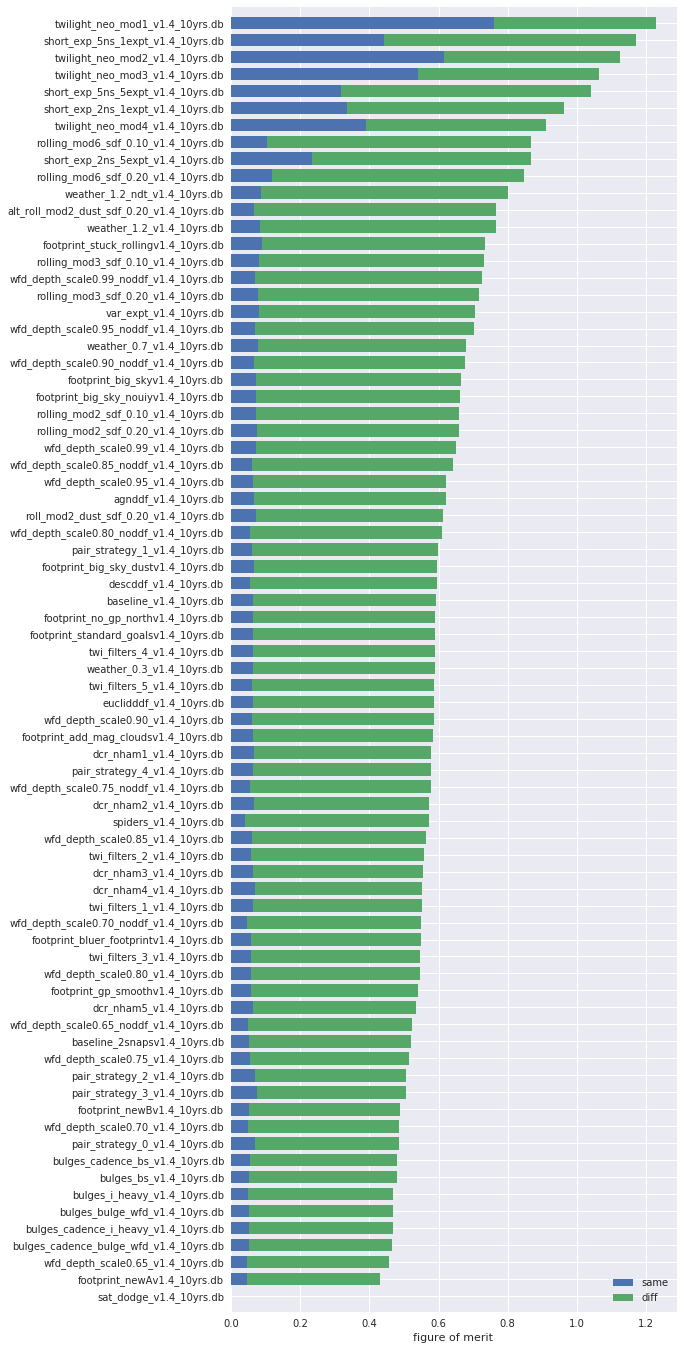

In [86]:
df_new = df_fom.sort_values(by='total', ascending=True)

plt.style.use('seaborn')
plt.figure(figsize=(8,24))

labels = df_new.db.values
fom_same = df_new['same'].values
fom_diff = df_new['diff'].values

width = 0.2
pos = np.linspace(0, 20, 76)
plt.barh(pos, fom_same, width, label='same', align='center')
plt.barh(pos, fom_diff, width, left=fom_same, label='diff')

plt.yticks(pos, labels)
plt.xlabel('figure of merit ')
plt.ylim([-.25, 20.25])
plt.legend()

sky coverage

In [89]:
def cal_nvisits(df):
    '''return nvisits for a filter pair'''
    dT = df['dT']
    return len(dT)


In [90]:
def get_Nfields(dbfile='', path='', Nlim_same=5000, Nlim_diff=5000, night=[0, 4000]):

    filename = path + dbfile
    df_all = pd.read_csv(filename, 
                     converters={'t_f0':to_array, 't_f1':to_array})
    
    print('loaded ', filename)

    df_all['diffmat'] = df_all.apply(cal_diffmat, axis=1, night=night)
    df_all['dT'] = df_all.apply(cal_dT, axis=1)
    df_all['Nvisits'] = df_all.apply(cal_nvisits, axis=1)
    print('calculating Nfields')
    
    flt = ['u', 'g', 'r', 'i', 'z', 'y']
    
    Nfields_dict = {}
    for i, f0 in enumerate(flt):
        for f1 in flt[i:]:
            
            key = '{}{}'.format(f0, f1)
            df = df_all[ (df_all['f0']==f0) & (df_all['f1']==f1) ].copy()

            if f0==f1:
                x = df['ra'].values
                y = df['dec'].values
                c = df['Nvisits'].values > Nlim_same
                Nf = c.sum()
                #title = '{}{} Dkl {}'.format(f0, f1)
                #plot_mwd(ax, x, y, c, title=title, vmax=1)

            else:
                x = df['ra'].values
                y = df['dec'].values
                c = df['Nvisits'].values > Nlim_diff
                Nf = c.sum()

                #title = '{}{} Dkl {}'.format(f0, f1)
                #plot_mwd(ax, x, y, c, title=title, vmax=1)
            Nfields_dict[key] = Nf

            print(key, Nf)
    
    return Nfields_dict


In [92]:
%%time
# run for all opsims
path = '/home/idies/workspace/Temporary/lixl/scratch/'

#cols = ['db', 'uu', 'ug', 'ur', 'ui', 'uz', 'uy', 'gg', 'gr', 'gi', 'gz', 'gy', 'rr', 'ri', 'rz', 'ry', 'ii', 'iz', 'iy', 'zz', 'zy', 'yy']

#with open('Nfields.csv', 'w') as f:
#    head = str(cols).replace('[','').replace(']', '')
#    f.write("{}\n".format(head) )
    
for dbname in dblist_all:
    dbfile = 'tGaps_{}_nside16_proposalId=1.csv'.format(dbname)
    Nfields_dict = get_Nfields(dbfile=dbfile, path=path, Nlim_same=3000, Nlim_diff=3000)
    print('Nfields of {}'.format(dbname) )
    
    with open('Nfields_th3000.csv', 'a') as f:
        lsr = "{}, {}".format(dbname, list( Nfields_dict.values() ) ).replace('[','').replace(']', '') 
        f.write("{}\n".format(lsr) )


loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_agnddf_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating Nfields
uu 16
ug 1337
ur 1351
ui 1351
uz 1349
uy 1350
gg 1157
gr 1353
gi 1353
gz 1352
gy 1352
rr 1354
ri 1401
rz 1385
ry 1396
ii 1354
iz 1392
iy 1398
zz 1352
zy 1381
yy 1353
Nfields of agnddf_v1.4_10yrs.db
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db_nside16_proposalId=1.csv
calculating Nfields
uu 5
ug 1206
ur 1369
ui 1371
uz 1369
uy 1369
gg 360
gr 1382
gi 1380
gz 1377
gy 1381
rr 1393
ri 1418
rz 1416
ry 1418
ii 1390
iz 1418
iy 1420
zz 1382
zy 1417
yy 1390
Nfields of alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db
loaded  /home/idies/workspace/Temporary/lixl/scratch/tGaps_baseline_2snapsv1.4_10yrs.db_nside16_proposalId=1.csv
calculating Nfields
uu 0
ug 1304
ur 1347
ui 1347
uz 1345
uy 1345
gg 291
gr 1351
gi 1352
gz 1350
gy 1350
rr 1353
ri 1364
rz 1359
ry 1362
ii 1354
iz 1361
iy 1361
zz 1352
zy 1361
yy 1354
Nfields of baseli

In [94]:
df_Nfields = pd.read_csv('Nfields_th3000.csv', names=cols)
df_Nfields.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,agnddf_v1.4_10yrs.db,16,1337,1351,1351,1349,1350,1157,1353,1353,...,1354,1401,1385,1396,1354,1392,1398,1352,1381,1353
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,5,1206,1369,1371,1369,1369,360,1382,1380,...,1393,1418,1416,1418,1390,1418,1420,1382,1417,1390
2,baseline_2snapsv1.4_10yrs.db,0,1304,1347,1347,1345,1345,291,1351,1352,...,1353,1364,1359,1362,1354,1361,1361,1352,1361,1354
3,baseline_v1.4_10yrs.db,3,1339,1351,1351,1350,1351,906,1354,1354,...,1354,1392,1378,1383,1354,1381,1383,1353,1371,1353
4,bulges_bs_v1.4_10yrs.db,1,1129,1224,1224,1222,1224,161,1227,1227,...,1228,1237,1230,1243,1227,1230,1248,1226,1236,1227


In [95]:
df_Nfields['Nsum'] = np.sum( df_Nfields[cols[1:]], axis=1 )
df_Nfields['fom_Nf'] = np.sum( df_Nfields[cols[1:]], axis=1 ) / (1400*21) 

df_Nfields.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rz,ry,ii,iz,iy,zz,zy,yy,Nsum,fom_Nf
0,agnddf_v1.4_10yrs.db,16,1337,1351,1351,1349,1350,1157,1353,1353,...,1385,1396,1354,1392,1398,1352,1381,1353,27087,0.921327
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,5,1206,1369,1371,1369,1369,360,1382,1380,...,1416,1418,1390,1418,1420,1382,1417,1390,26631,0.905816
2,baseline_2snapsv1.4_10yrs.db,0,1304,1347,1347,1345,1345,291,1351,1352,...,1359,1362,1354,1361,1361,1352,1361,1354,25963,0.883095
3,baseline_v1.4_10yrs.db,3,1339,1351,1351,1350,1351,906,1354,1354,...,1378,1383,1354,1381,1383,1353,1371,1353,26768,0.910476
4,bulges_bs_v1.4_10yrs.db,1,1129,1224,1224,1222,1224,161,1227,1227,...,1230,1243,1227,1230,1248,1226,1236,1227,23425,0.796769


In [96]:
df_Nfields.sort_values(by='Nsum', ascending=False).head()


,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rz,ry,ii,iz,iy,zz,zy,yy,Nsum,fom_Nf
58,weather_1.2_ndt_v1.4_10yrs.db,1198,1351,1356,1357,1355,1355,1344,1389,1392,...,1447,1447,1419,1447,1445,1391,1445,1400,29166,0.992041
59,weather_1.2_v1.4_10yrs.db,890,1347,1356,1356,1355,1354,1341,1371,1367,...,1446,1446,1388,1443,1443,1371,1442,1372,28656,0.974694
43,short_exp_5ns_1expt_v1.4_10yrs.db,863,1345,1352,1352,1353,1352,1341,1362,1360,...,1433,1440,1375,1431,1439,1360,1431,1364,28473,0.968469
44,short_exp_5ns_5expt_v1.4_10yrs.db,730,1343,1353,1353,1352,1353,1339,1356,1356,...,1434,1438,1369,1434,1438,1357,1431,1377,28322,0.963333
57,weather_0.7_v1.4_10yrs.db,127,1339,1353,1353,1352,1353,1337,1354,1354,...,1420,1425,1358,1426,1424,1355,1420,1359,27605,0.938946


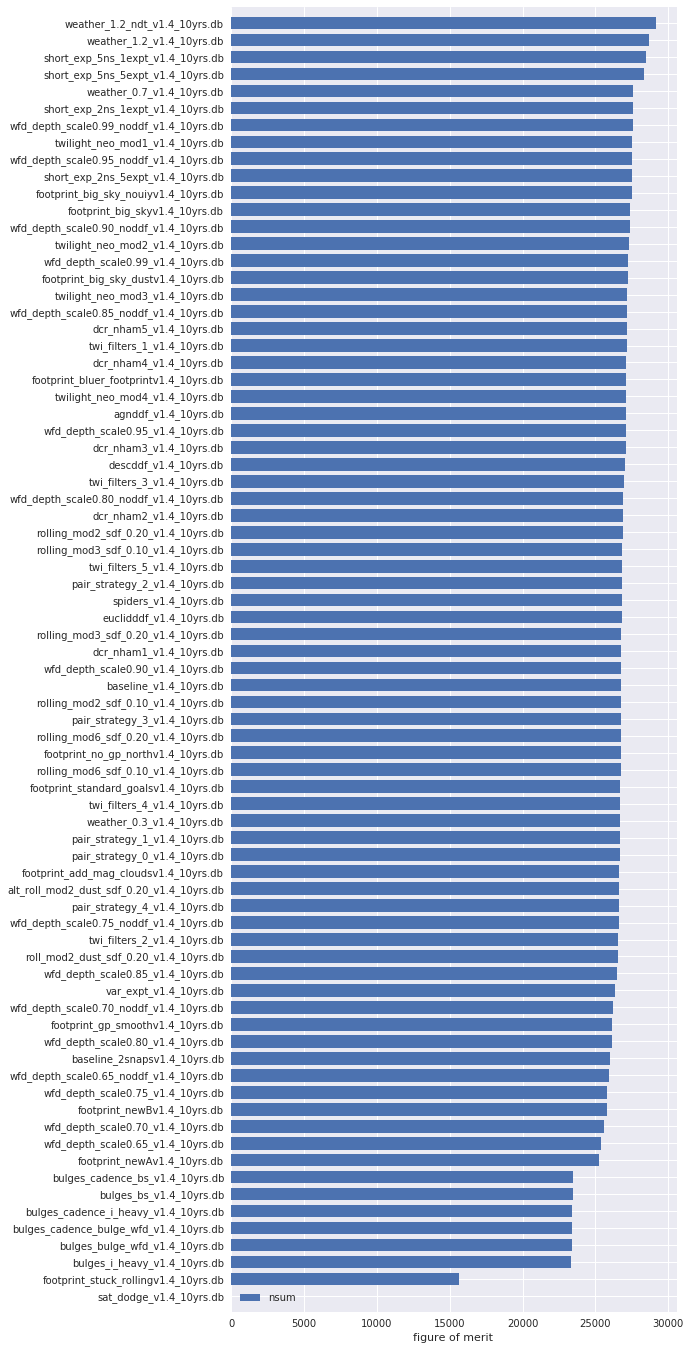

In [116]:
plt.figure(figsize=(8,24))
df_new = df_Nfields.sort_values(by='Nsum', ascending=True)

labels = df_new.db.values
Nsum = df_new['Nsum'].values
#fom_diff = df_new.fom_diff_final.values

width = 0.2
pos = np.linspace(0, 20, 76)
plt.barh(pos, Nsum, width, label='nsum', align='center')
#plt.barh(pos, fom_diff, width, left=fom_same, label='diff')

plt.yticks(pos, labels)
plt.xlabel('figure of merit ')
plt.ylim([-.25, 20.25])
plt.legend()


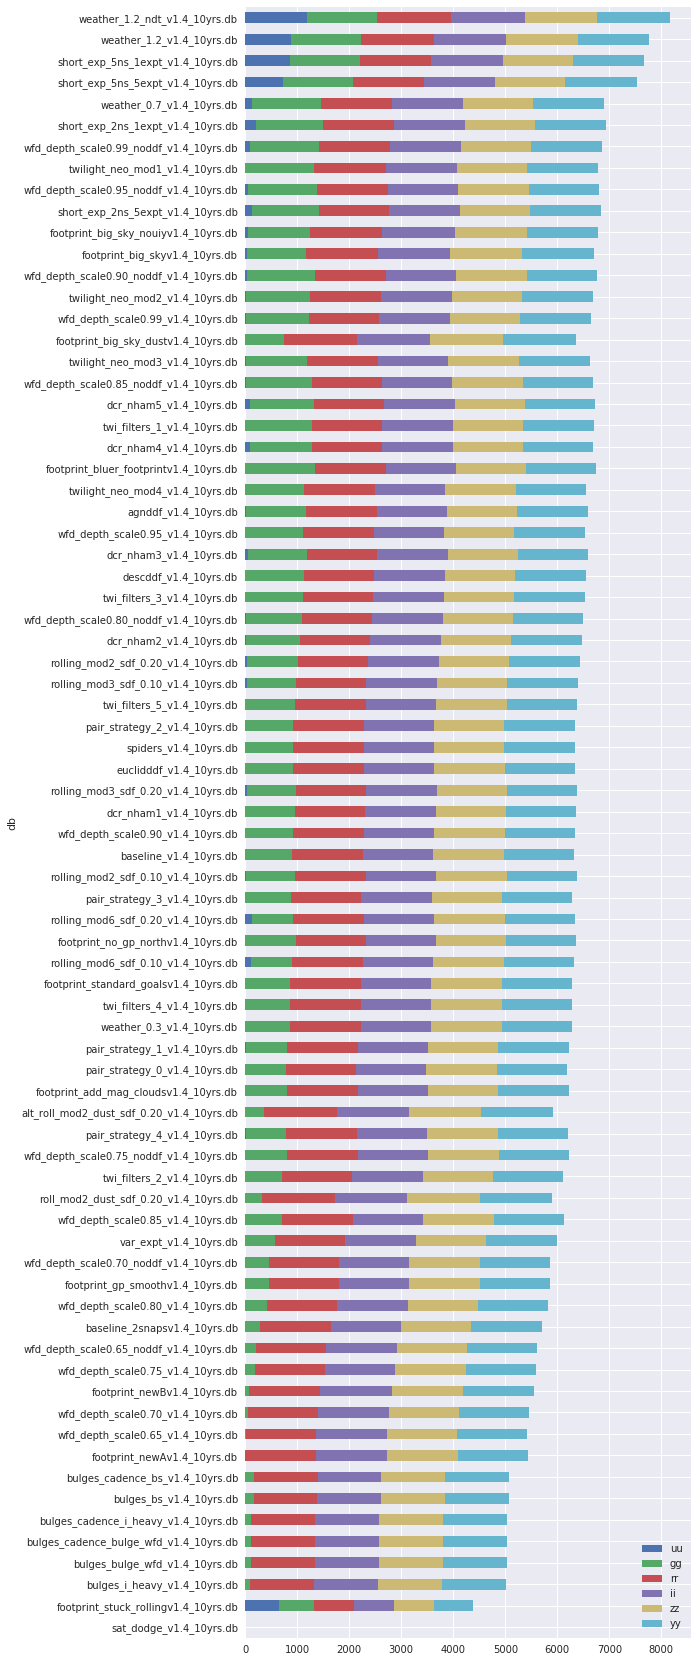

In [118]:

df_ = df_new.set_index('db')
df_[cols_same].plot.barh( figsize=(8, 30) , stacked=True)


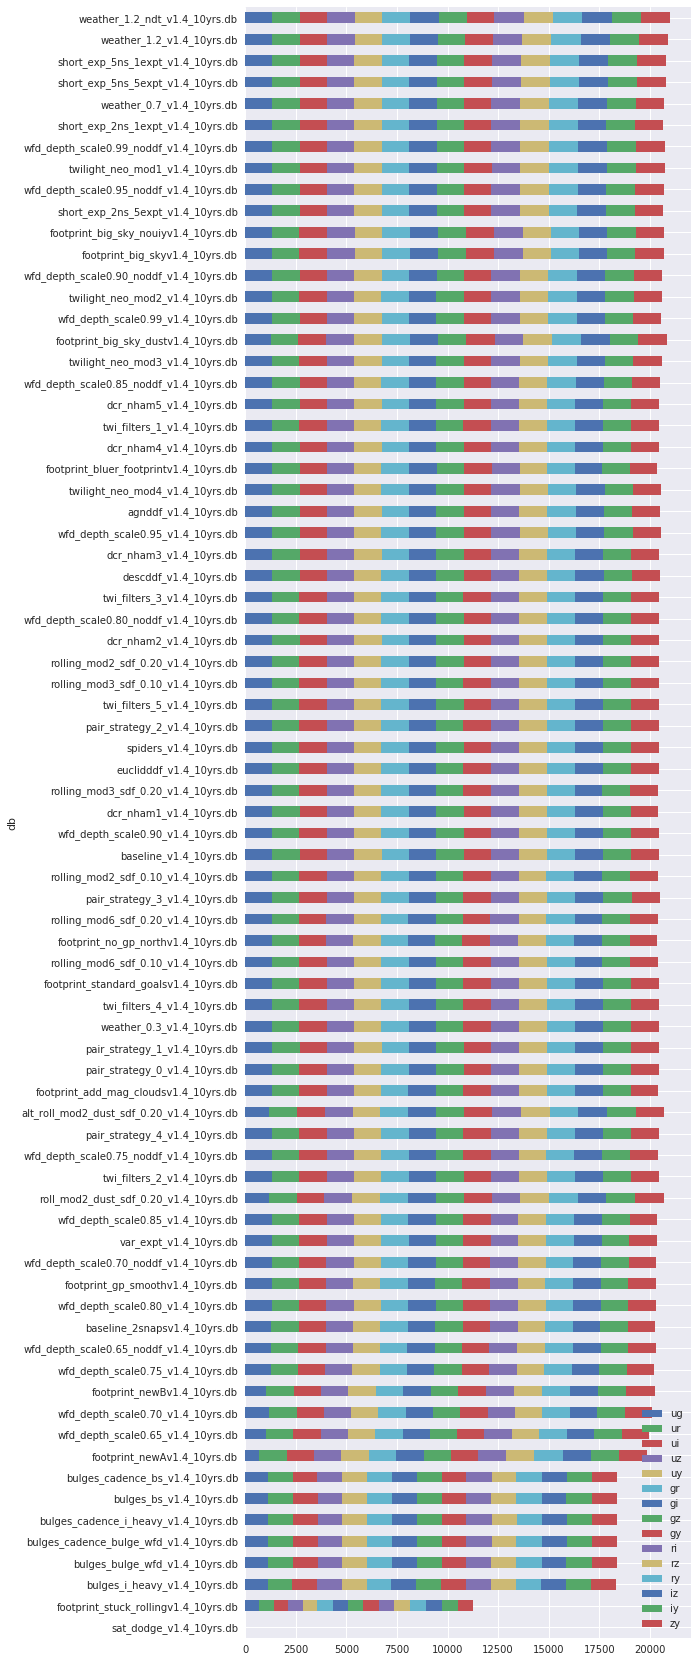

In [114]:
df_ = df_new.set_index('db')
df_[cols_diff].plot.barh( figsize=(8, 30) , stacked=True)


In [130]:
df_starDensity = pd.read_csv('starDensity_nside16.csv')
df_starDensity.head()

,field,ra,dec,density
0,1,2.756895,3.658514,5976
1,2,8.482178,3.668233,5112
2,3,13.995028,3.684040,5688
3,4,19.620712,3.615434,5832
4,5,25.371389,3.646800,5724


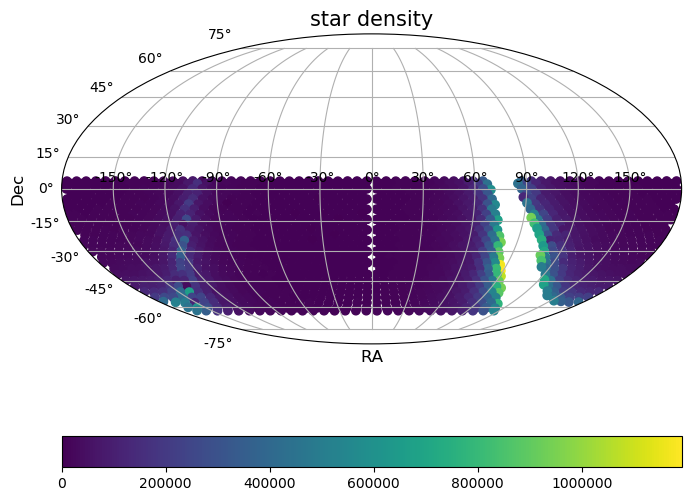

In [136]:
plt.style.use('default')
x = df_starDensity['ra']
y = df_starDensity['dec']
c = df_starDensity['density']

fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
plot_mwd(ax, x, y, c, title='star density') 

In [131]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmax=None):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=0, vmax=vmax)  # convert degrees to radians
    # ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)


In [119]:
import healpy as hp

In [121]:
pixarea = hp.nside2pixarea(nside=16, degrees=True)
pixarea

13.428698323378669

In [123]:
df_nfields = pd.read_csv('Nfields_th3000.csv', names=cols)
df_nfields.head()

,db,uu,ug,ur,ui,uz,uy,gg,gr,gi,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,agnddf_v1.4_10yrs.db,16,1337,1351,1351,1349,1350,1157,1353,1353,...,1354,1401,1385,1396,1354,1392,1398,1352,1381,1353
1,alt_roll_mod2_dust_sdf_0.20_v1.4_10yrs.db,5,1206,1369,1371,1369,1369,360,1382,1380,...,1393,1418,1416,1418,1390,1418,1420,1382,1417,1390
2,baseline_2snapsv1.4_10yrs.db,0,1304,1347,1347,1345,1345,291,1351,1352,...,1353,1364,1359,1362,1354,1361,1361,1352,1361,1354
3,baseline_v1.4_10yrs.db,3,1339,1351,1351,1350,1351,906,1354,1354,...,1354,1392,1378,1383,1354,1381,1383,1353,1371,1353
4,bulges_bs_v1.4_10yrs.db,1,1129,1224,1224,1222,1224,161,1227,1227,...,1228,1237,1230,1243,1227,1230,1248,1226,1236,1227


In [127]:
df_nfields[cols[1:]] * pixarea

,uu,ug,ur,ui,uz,uy,gg,gr,gi,gz,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,214.859173,17954.169658,18142.171435,18142.171435,18115.314038,18128.742737,15537.003960,18169.028832,18169.028832,18155.600133,...,18182.457530,18813.606351,18598.747178,18746.462859,18182.457530,18692.748066,18773.320256,18155.600133,18545.032385,18169.028832
1,67.143492,16195.010178,18383.888005,18410.745401,18383.888005,18383.888005,4834.331396,18558.461083,18531.603686,18491.317591,...,18706.176764,19041.894223,19015.036826,19041.894223,18665.890669,19041.894223,19068.751619,18558.461083,19028.465524,18665.890669
2,0.000000,17511.022614,18088.456642,18088.456642,18061.599245,18061.599245,3907.751212,18142.171435,18155.600133,18128.742737,...,18169.028832,18316.744513,18249.601021,18289.887116,18182.457530,18276.458418,18276.458418,18155.600133,18276.458418,18182.457530
3,40.286095,17981.027055,18142.171435,18142.171435,18128.742737,18142.171435,12166.400681,18182.457530,18182.457530,18169.028832,...,18182.457530,18692.748066,18504.746290,18571.889781,18182.457530,18545.032385,18571.889781,18169.028832,18410.745401,18169.028832
4,13.428698,15161.000407,16436.726748,16436.726748,16409.869351,16436.726748,2162.020430,16477.012843,16477.012843,16463.584144,...,16490.441541,16611.299826,16517.298938,16691.872016,16477.012843,16517.298938,16759.015508,16463.584144,16597.871128,16477.012843
5,0.000000,15201.286502,16436.726748,16423.298049,16423.298049,16423.298049,1638.301195,16477.012843,16477.012843,16463.584144,...,16490.441541,16571.013731,16530.727636,16718.729413,16490.441541,16544.156334,16705.300714,16463.584144,16584.442429,16477.012843
6,26.857397,15147.571709,16436.726748,16436.726748,16409.869351,16436.726748,2175.449128,16490.441541,16490.441541,16463.584144,...,16490.441541,16705.300714,16503.870239,16638.157223,16477.012843,16571.013731,16772.444206,16450.155446,16557.585033,16463.584144
7,13.428698,15228.143899,16450.155446,16450.155446,16409.869351,16409.869351,1571.157704,16490.441541,16477.012843,16450.155446,...,16490.441541,16584.442429,16544.156334,16745.586809,16490.441541,16544.156334,16732.158111,16463.584144,16651.585921,16463.584144
8,0.000000,15120.714312,16463.584144,16490.441541,16463.584144,16477.012843,1638.301195,16450.155446,16463.584144,16450.155446,...,16463.584144,16691.872016,16530.727636,16691.872016,16517.298938,16611.299826,16745.586809,16436.726748,16584.442429,16477.012843
9,13.428698,14972.998631,16396.440653,16423.298049,16383.011955,16409.869351,1369.727229,16477.012843,16490.441541,16463.584144,...,16477.012843,16638.157223,16503.870239,16651.585921,16503.870239,16571.013731,16705.300714,16450.155446,16584.442429,16490.441541


In [ ]:
'/home/idies/workspace/Temporary/lixl/scratch/'

In [138]:
temp = '/home/idies/workspace/Temporary/lixl/scratch/'
df_nv = pd.read_csv(temp + 'tGaps_baseline_v1.4_10yrs.db_nside16_proposalId=1_Nv.csv')


In [140]:
df_nv

,field,ra,dec,f0,f1,Nv
0,1,2.756895,3.658514,u,u,18
1,1,2.756895,3.658514,u,g,7
2,1,2.756895,3.658514,u,r,1
3,1,2.756895,3.658514,u,i,0
4,1,2.756895,3.658514,u,z,0
5,1,2.756895,3.658514,u,y,0
6,1,2.756895,3.658514,g,g,24
7,1,2.756895,3.658514,g,r,41
8,1,2.756895,3.658514,g,i,2
9,1,2.756895,3.658514,g,z,3


In [142]:
flt = ['u', 'g', 'r', 'i', 'z', 'y']

In [152]:
df_new = df_nv[(df_nv.f0=='u') & (df_nv.f1=='u')].reset_index() [[ 'field', 'ra', 'dec' ]]
df_new.head()

,field,ra,dec
0,1,2.756895,3.658514
1,2,8.482178,3.668233
2,3,13.995028,3.684040
3,4,19.620712,3.615434
4,5,25.371389,3.646800


In [157]:
df_new.head()

,field,ra,dec,uu
0,1,2.756895,3.658514,18
1,2,8.482178,3.668233,12
2,3,13.995028,3.684040,19
3,4,19.620712,3.615434,22
4,5,25.371389,3.646800,16


In [163]:
df_new = df_nv[(df_nv.f0=='u') & (df_nv.f1=='u')].reset_index() [[ 'field', 'ra', 'dec' ]]

for i, f0 in enumerate(flt):
    for f1 in flt[i:]:
        print(f0,f1)
        key = '{}{}'.format(f0, f1)
        df_new[key] = df_nv[ (df_nv.f0==f0) & (df_nv.f1==f1) ]['Nv'].values

u u
u g
u r
u i
u z
u y
g g
g r
g i
g z
g y
r r
r i
r z
r y
i i
i z
i y
z z
z y
y y


In [165]:
df_new.head()

,field,ra,dec,uu,ug,ur,ui,uz,uy,gg,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,1,2.756895,3.658514,18,7,1,0,0,0,24,...,57,17,6,5,52,36,7,50,23,45
1,2,8.482178,3.668233,12,6,2,2,0,0,16,...,42,24,4,1,56,26,10,44,28,60
2,3,13.995028,3.684040,19,6,5,2,0,0,16,...,48,35,7,0,59,29,3,45,12,35
3,4,19.620712,3.615434,22,8,6,2,0,0,18,...,47,16,4,1,43,24,4,54,34,43
4,5,25.371389,3.646800,16,9,6,1,0,0,24,...,50,18,2,1,62,32,5,54,28,43


In [166]:
ls

Nfields.csv                        filterPairTGaps_output_10yr_v1.5
Nfields_th3000.csv                 fom.csv
analysis.ipynb                     fom_all.csv
analysis_2.ipynb                   fom_all_10yrs.csv
analysis_filterTGaps-Copy1.ipynb   fom_all_new.csv
analysis_filterTGaps-Copy2.ipynb   history/
analysis_filterTGaps.ipynb         outDir/
calTGaps.ipynb                     output.txt
data/                              run.ipynb
fig.png                            sqlite.ipynb
filterPairTGapsMetric-Copy1.ipynb  starDensity_nside16.csv
filterPairTGapsMetric.ipynb        test.csv
filterPairTGaps_output             test.txt
filterPairTGaps_output_10yr        tgaps_Nv.csv
filterPairTGaps_output_10yr_temp   tgaps_fom.csv


In [167]:
df_density = pd.read_csv('starDensity_nside16.csv')
df_density.head()

,field,ra,dec,density
0,1,2.756895,3.658514,5976
1,2,8.482178,3.668233,5112
2,3,13.995028,3.684040,5688
3,4,19.620712,3.615434,5832
4,5,25.371389,3.646800,5724


In [169]:
df_new.merge(df_density, on=['field', 'ra', 'dec'] ) 

,field,ra,dec,uu,ug,ur,ui,uz,uy,gg,...,ri,rz,ry,ii,iz,iy,zz,zy,yy,density
0,3,13.995028,3.684040,19,6,5,2,0,0,16,...,35,7,0,59,29,3,45,12,35,5688
1,18,98.499252,3.666320,13,3,0,0,0,0,24,...,28,1,1,58,30,7,48,23,39,24408
2,34,188.474532,3.699078,11,7,2,2,0,0,23,...,29,6,4,66,49,17,58,52,51,6948
3,42,233.322559,3.653173,16,10,3,3,2,0,27,...,41,10,5,61,24,5,47,31,67,18756
4,56,329.129275,3.643288,14,3,1,0,0,0,28,...,29,4,1,53,33,5,46,18,48,17748
5,69,39.331850,2.413103,50,44,34,16,2,2,77,...,183,45,29,181,110,50,162,184,177,5508
6,87,140.586703,2.399166,75,62,72,21,2,0,77,...,197,54,23,205,182,83,180,255,192,10620
7,88,146.274614,2.463131,54,53,57,15,0,0,77,...,195,49,15,203,200,93,186,313,193,8388
8,108,258.730611,2.451569,62,43,30,12,6,0,82,...,153,58,21,210,238,81,189,177,205,78912
9,115,309.386231,2.389546,69,28,29,7,2,0,88,...,198,62,15,205,178,56,176,176,176,52020


In [170]:
df_new.head()

,field,ra,dec,uu,ug,ur,ui,uz,uy,gg,...,rr,ri,rz,ry,ii,iz,iy,zz,zy,yy
0,1,2.756895,3.658514,18,7,1,0,0,0,24,...,57,17,6,5,52,36,7,50,23,45
1,2,8.482178,3.668233,12,6,2,2,0,0,16,...,42,24,4,1,56,26,10,44,28,60
2,3,13.995028,3.684040,19,6,5,2,0,0,16,...,48,35,7,0,59,29,3,45,12,35
3,4,19.620712,3.615434,22,8,6,2,0,0,18,...,47,16,4,1,43,24,4,54,34,43
4,5,25.371389,3.646800,16,9,6,1,0,0,24,...,50,18,2,1,62,32,5,54,28,43
